/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


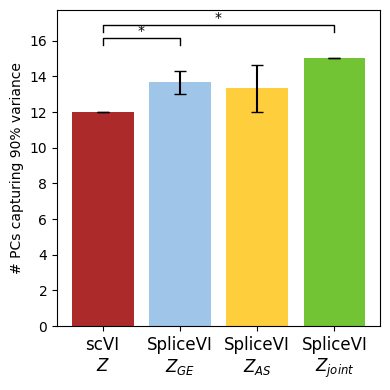

In [5]:
# --- FIGURE: # of PCs capturing 90% variance ---
# Now: each value can be either a single number or a list of numbers (replicates)
pc90_values = {
    "scVI\n$Z$": [12, 12, 12],
    "SpliceVI\n$Z_{GE}$": [13, 14, 14],
    "SpliceVI\n$Z_{AS}$": [12, 14, 14],
    "SpliceVI\n$Z_{joint}$": [15, 15, 15],
}


colors = [ "#ad2a2a",  "#9fc5e8ff","#ffce3cff", "#73c434"]
# ---- plotting (matplotlib only) ----
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import ttest_ind


def add_sig_bracket(ax, x1, x2, y, h, text):
    """
    Draws a significance bracket between x1 and x2 at height y,
    with vertical height h and label `text` (e.g. "*").
    """
    ax.plot([x1, x1, x2, x2],
            [y,  y + h, y + h, y],
            color="black", linewidth=1)
    ax.text((x1 + x2) / 2.0, y + h, text,
            ha="center", va="bottom")


labels = list(pc90_values.keys())

means = []
errors = []          # 95% CI half-widths
replicates = []      # store raw values for t tests

for k in labels:
    v = pc90_values[k]
    # normalize to list
    if not isinstance(v, (list, tuple, np.ndarray)):
        v = [v]
    v = np.array(v, dtype=float)

    replicates.append(v)

    mean = v.mean()
    n = len(v)

    if n > 1:
        # 95% CI assuming approx normal: 1.96 * (SD / sqrt(n))
        se = v.std(ddof=1) / np.sqrt(n)
        ci95 = 1.96 * se
    else:
        ci95 = 0.0

    means.append(mean)
    errors.append(ci95)

means = np.array(means)
errors = np.array(errors)

x = np.arange(len(labels))

plt.figure(figsize=(4, 4))
plt.bar(x, means, yerr=errors, capsize=4, color=colors, linewidth=0)
plt.xticks(x, labels, ha="center", fontsize = 12)
plt.ylabel("# PCs capturing 90% variance")

ax = plt.gca()

# --- pairwise t tests and significance annotations ---
significant_pairs = []
alpha = 0.05

for (i, j) in combinations(range(len(labels)), 2):
    v1 = replicates[i]
    v2 = replicates[j]

    # independent samples t test, unequal variances
    stat, p = ttest_ind(v1, v2, equal_var=False)

    if p < alpha:
        significant_pairs.append((i, j, p))

# Only draw brackets for significant pairs
if significant_pairs:
    # Base height just above the tallest error bar
    y_max = float(np.max(means + errors))
    # Vertical spacing between brackets
    step = 0.05 * y_max if y_max > 0 else 0.5
    h = 0.5 * step

    for idx, (i, j, p) in enumerate(significant_pairs):
        y = y_max + step + idx * step
        add_sig_bracket(ax, x[i], x[j], y, h, "*")

plt.tight_layout()
plt.savefig("fig_pc90.pdf", dpi=300, bbox_inches="tight")
plt.show()


[(0, 2, np.float64(0.000915674842263548)), (1, 2, np.float64(0.00021949372339798173)), (2, 3, np.float64(1.9540990004600166e-05))]


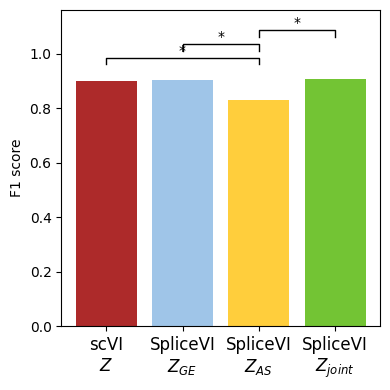

In [7]:
# --- FIGURE: F1 score of cell-type classification ---
# Each entry can be a single float or a list of floats (replicates)
f1_values = {
    "scVI\n$Z$": [0.90123, 0.90219, 0.90219],
    "SpliceVI\n$Z_{GE}$": [0.90435, 0.90406, 0.90706],
    "SpliceVI\n$Z_{AS}$": [0.83521, 0.82849, 0.82778],
    "SpliceVI\n$Z_{joint}$": [0.90485, 0.90514, 0.91122],
}

colors = [ "#ad2a2a",  "#9fc5e8ff","#ffce3cff", "#73c434"]

# ---- plotting (matplotlib only) ----
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import ttest_ind


def add_sig_bracket(ax, x1, x2, y, h, text):
    """
    Draws a significance bracket between x1 and x2 at height y,
    with vertical height h and label `text` (e.g. "*").
    """
    ax.plot([x1, x1, x2, x2],
            [y,  y + h, y + h, y],
            color="black", linewidth=1)
    ax.text((x1 + x2) / 2.0, y + h, text,
            ha="center", va="bottom")


labels = list(f1_values.keys())

means = []
errors = []          # 95% CI half-widths
replicates = []      # store raw values for t tests

for k in labels:
    v = f1_values[k]
    if not isinstance(v, (list, tuple, np.ndarray)):
        v = [v]
    v = np.array(v, dtype=float)

    replicates.append(v)

    mean = v.mean()
    n = len(v)

    if n > 1:
        se = v.std(ddof=1) / np.sqrt(n)
        ci95 = 1.96 * se
    else:
        ci95 = 0.0

    means.append(mean)
    errors.append(ci95)

means = np.array(means)
errors = np.array(errors)

x = np.arange(len(labels))

plt.figure(figsize=(4, 4))
plt.bar(x, means, capsize=4, color=colors)
plt.xticks(x, labels, ha="center", fontsize = 12)
plt.ylabel("F1 score")

ax = plt.gca()

# --- pairwise t tests and significance annotations ---
significant_pairs = []
alpha = 0.05

for (i, j) in combinations(range(len(labels)), 2):
    v1 = replicates[i]
    v2 = replicates[j]

    # Welch's t test (independent, unequal variances)
    stat, p = ttest_ind(v1, v2, equal_var=False)

    if p < alpha:
        significant_pairs.append((i, j, p))

print (significant_pairs)
if significant_pairs:
    # Base height just above the tallest error bar
    y_max = float(np.max(means + errors))
    step = 0.05  # absolute height step in F1 units
    h = 0.5 * step

    # Make sure we have room for brackets
    top = max(1.0, y_max + step * (len(significant_pairs) + 2))
    ax.set_ylim(0, top)
    # Limit displayed tick labels to <= 1.0
    ticks = ax.get_yticks()
    ax.set_yticks([t for t in ticks if t <= 1.0])


    for idx, (i, j, p) in enumerate(significant_pairs):
        y = y_max + step + idx * step
        add_sig_bracket(ax, x[i], x[j], y, h, "*")
else:
    ax.set_ylim(0, 1.0)

plt.tight_layout()
plt.savefig("fig_f1.pdf", dpi=300, bbox_inches="tight")
plt.show()


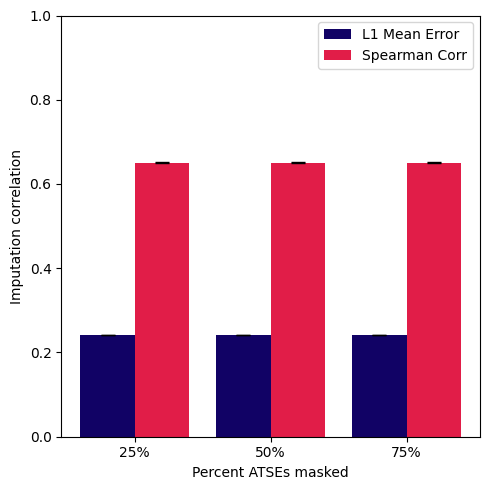

In [6]:
# --- FIGURE: Imputation accuracy vs % masked ---
# USER INPUT: values can be single floats or lists (replicates)
impute_values = {
    "25%": {
        "Spearman Corr": [0.6511007496853309, 0.6512170931193155, 0.6490647671510403],
        "L1 Mean Error": [0.2410713136196136, 0.2408642619848251, 0.241405114531517],
    },
    "50%": {
        "Spearman Corr": [0.651209360051504, 0.6512467005405398, 0.6491951728355002],
        "L1 Mean Error": [0.2410814762115478, 0.2408788800239563, 0.2414129078388214],
    },
    "75%": {
        "Spearman Corr": [0.6516948548894853, 0.6515731551656743, 0.6496497676029787],
        "L1 Mean Error": [0.2410573214292526, 0.2408928722143173, 0.2414392083883285],
    },
}


colors = ["#110265", "#E11D48"]

# ---- plotting ----
import numpy as np
import matplotlib.pyplot as plt

masks = list(impute_values.keys())
models = sorted({m for d in impute_values.values() for m in d.keys()})
x = np.arange(len(masks))
width = 0.8 / max(1, len(models))  # bar width

plt.figure(figsize=(5, 5))

for i, model in enumerate(models):
    means = []
    errors = []

    for p in masks:
        v = impute_values[p].get(model, np.nan)

        # Normalize to list
        if isinstance(v, (list, tuple, np.ndarray)):
            v = np.array(v, dtype=float)
        else:
            v = np.array([v], dtype=float)

        means.append(v.mean())

        if len(v) > 1:
            se = v.std(ddof=1) / np.sqrt(len(v))
            ci95 = 1.96 * se
        else:
            ci95 = 0.0

        errors.append(ci95)

    means = np.array(means)
    errors = np.array(errors)

    xpos = x + i * width - (len(models) - 1) * width / 2

    plt.bar(
        xpos,
        means,
        width=width,
        label=model,
        color=colors[i],
        yerr=errors,
        capsize=5
    )

plt.xticks(x, masks)
plt.ylim(0, 1.0)
plt.xlabel("Percent ATSEs masked")
plt.ylabel("Imputation correlation")
plt.legend()
plt.tight_layout()
plt.savefig("fig_impute.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [111]:
nmf_path = "/gpfs/commons/groups/knowles_lab/Karin/nmf_imputation_results_comprehensive.csv"
nmf_results = pd.read_csv(nmf_path)
nmf_results.head()

,n_components,mask_percent,n_masked_values,pearson_r,pearson_p,spearman_r,spearman_p,l1_mae,rmse,test_path
0,20,25%,34420861,0.291675,0.0,0.235445,0.0,0.511491,0.592113,MASKED_25_PERCENT_test_30_70_model_ready_combi...
1,20,50%,68872440,0.291218,0.0,0.235105,0.0,0.588581,0.655275,MASKED_50_PERCENT_test_30_70_model_ready_combi...
2,20,75%,103308614,0.290297,0.0,0.234621,0.0,0.668943,0.728115,MASKED_75_PERCENT_test_30_70_model_ready_combi...
3,30,25%,34420861,0.292424,0.0,0.235919,0.0,0.510578,0.591218,MASKED_25_PERCENT_test_30_70_model_ready_combi...
4,30,50%,68872440,0.291848,0.0,0.235483,0.0,0.587947,0.654654,MASKED_50_PERCENT_test_30_70_model_ready_combi...


[0.24107131 0.24086426 0.24140511]
[0.24108148 0.24087888 0.24141291]
[0.24105732 0.24089287 0.24143921]


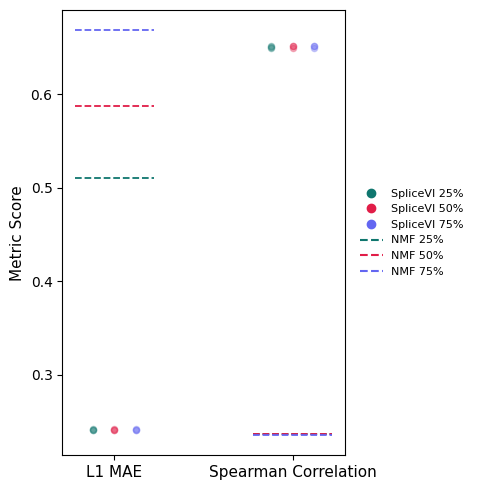

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1. Load NMF results
# ------------------------------------------------
nmf_path = "/gpfs/commons/groups/knowles_lab/Karin/nmf_imputation_results_comprehensive.csv"
nmf_results = pd.read_csv(nmf_path)

mask_levels = ["25%", "50%", "75%"]
nmf_results = nmf_results[nmf_results["mask_percent"].isin(mask_levels)]

def ci95(x):
    x = np.asarray(x, float)
    if len(x) < 2:
        return 0.0
    se = x.std(ddof=1) / np.sqrt(len(x))
    return 1.96 * se

nmf_group = nmf_results.groupby("mask_percent")
nmf_spear_mean = nmf_group["spearman_r"].mean()
nmf_l1_mean    = nmf_group["l1_mae"].mean()

# ------------------------------------------------
# 2. SpliceVI results
# ------------------------------------------------
impute_values = {
    "25%": {
        "Spearman Corr": [0.6511007496853309, 0.6512170931193155, 0.6490647671510403],
        "L1 Mean Error": [0.2410713136196136, 0.2408642619848251, 0.241405114531517],
    },
    "50%": {
        "Spearman Corr": [0.651209360051504, 0.6512467005405398, 0.6491951728355002],
        "L1 Mean Error": [0.2410814762115478, 0.2408788800239563, 0.2414129078388214],
    },
    "75%": {
        "Spearman Corr": [0.6516948548894853, 0.6515731551656743, 0.6496497676029787],
        "L1 Mean Error": [0.2410573214292526, 0.2408928722143173, 0.2414392083883285],
    },
}

# Colors per masking %
mask_colors = {
    "25%": "#0F766E",   # teal
    "50%": "#E11D48",   # pink/magenta
    "75%": "#6366F1",   # indigo
}

# ------------------------------------------------
# 3. Plot setup
# ------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 5))

x_positions = [0, 1]   # 0 = L1, 1 = Spearman
metric_labels = ["L1 MAE", "Spearman Correlation"]
jit = [-0.12, 0.0, 0.12]   # horizontal offsets for each mask % to avoid overlap

# ------------------------------------------------
# 4. Plot SpliceVI points, means, CI bars, NMF baselines
# ------------------------------------------------
for idx, m in enumerate(mask_levels):
    c = mask_colors[m]
    jitter = jit[idx]

    # Extract raw values
    l1_vals = np.asarray(impute_values[m]["L1 Mean Error"], float)
    print(l1_vals)
    sp_vals = np.asarray(impute_values[m]["Spearman Corr"], float)

    # ---- SpliceVI raw scatter points ----
    ax.scatter(
        np.full_like(l1_vals, x_positions[0] + jitter),
        l1_vals,
        color=c,
        s=20,
        alpha=0.3
    )
    ax.scatter(
        np.full_like(sp_vals, x_positions[1] + jitter),
        sp_vals,
        color=c,
        s=20,
        alpha=0.3
    )

    # ---- Means and CI ----
    l1_mean = l1_vals.mean()
    sp_mean = sp_vals.mean()
    l1_ci = ci95(l1_vals)
    sp_ci = ci95(sp_vals)

    # CI + mean point
    # ax.errorbar(
    #     x_positions[0] + jitter,
    #     l1_mean,
    #     yerr=l1_ci,
    #     fmt="o",
    #     color=c,
    #     markersize=6,
    #     capsize=3,
    #     zorder=10,
    # )
    # ax.errorbar(
    #     x_positions[1] + jitter,
    #     sp_mean,
    #     yerr=sp_ci,
    #     fmt="o",
    #     color=c,
    #     markersize=6,
    #     capsize=3,
    #     zorder=10,
    # )

    # ---- NMF dashed baselines ----
    ax.hlines(
        nmf_l1_mean[m],
        x_positions[0] - 0.22,
        x_positions[0] + 0.22,
        colors=c,
        linestyles="dashed",
        linewidth=1.3,
    )
    ax.hlines(
        nmf_spear_mean[m],
        x_positions[1] - 0.22,
        x_positions[1] + 0.22,
        colors=c,
        linestyles="dashed",
        linewidth=1.3,
    )

# ------------------------------------------------
# 5. Axis formatting
# ------------------------------------------------
ax.set_xticks(x_positions)
ax.set_xticklabels(metric_labels, fontsize=11)
ax.set_ylabel("Metric Score", fontsize=11)

# ------------------------------------------------
# 6. Legend OUTSIDE the figure
# ------------------------------------------------
# Build legend entries
splice_handles = [
    plt.Line2D([0], [0], marker="o", linestyle="", color=mask_colors[m])
    for m in mask_levels
]
nmf_handles = [
    plt.Line2D([0], [0], linestyle="dashed", color=mask_colors[m])
    for m in mask_levels
]

legend_handles = splice_handles + nmf_handles
legend_labels = (
    [f"SpliceVI {m}" for m in mask_levels] +
    [f"NMF {m}" for m in mask_levels]
)

ax.legend(
    legend_handles,
    legend_labels,
    frameon=False,
    fontsize=8,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)


plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()


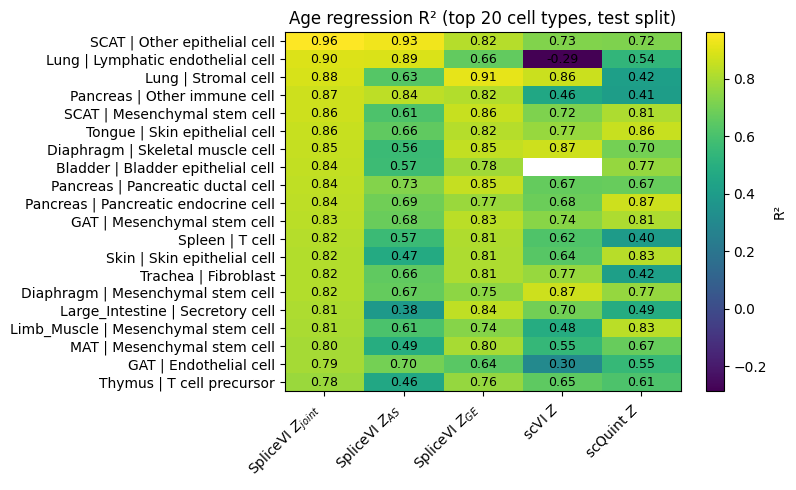

In [ ]:
# --- FIGURE: Age regression R² heatmap (top-N cell types, test split) ---
# USER INPUT:
splicevi_csv = "/gpfs/commons/home/svaidyanathan/splice_vi_partial_vae_sweep/batch_20251026_163736/mouse_trainandtest_REAL_cd=32_mn=50000_ld=25_lr=1e-5_0_scatter_PartialEncoderEDDI_pool=sum/figures/age_r2_by_tissue_celltype_train_test.csv"  # test metrics for SpliceVI
scvi_csv     = "/gpfs/commons/home/svaidyanathan/scvi_age/model/age_r2_by_tissue_celltype_train_test_target_ages_3_18_24_scvi_SCVI_age_only_20251024_143019.csv"      # test metrics for scVI
TOP_N = 20                                  # number of cell types to display

# ---- load, filter, and assemble table ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_age_r2(csv_path):
    df = pd.read_csv(csv_path)
    required = {"dataset","space","pair","r2"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns in {csv_path}: {missing}")
    # Standardize string cases
    df["dataset"] = df["dataset"].astype(str).str.lower()
    df["space"]   = df["space"].astype(str).str.lower()
    df["pair"] = df["pair"].astype(str)
    return df

# Load
sv = load_age_r2(splicevi_csv)
sc = load_age_r2(scvi_csv)

# Keep only TEST rows
sv = sv[sv["dataset"] == "test"].copy()
sc = sc[sc["dataset"] == "test"].copy()

# Extract SpliceVI three spaces
# Expect values among {"joint","splicing","expression"} for SpliceVI
want_spaces = ["joint","splicing","expression"]
sv = sv[sv["space"].isin(want_spaces)].copy()

# Pivot SpliceVI to wide: rows=pair, cols=SpliceVI spaces
sv_wide = sv.pivot_table(index="pair", columns="space", values="r2", aggfunc="mean")

# Rank cell types by SpliceVI joint R² (fallback: by row mean if joint missing)
if "joint" in sv_wide.columns:
    ranking = sv_wide["joint"].fillna(-1.0)
else:
    ranking = sv_wide.mean(axis=1).fillna(-1.0)

top_cells = ranking.sort_values(ascending=False).head(TOP_N).index.tolist()
sv_top = sv_wide.loc[top_cells]

# Get scVI (single Z)
# Some CSVs might label space simply as "z" or blank; if not present, take max per pair
if "space" in sc.columns:
    # Try to find a reasonable scVI space name; otherwise, collapse by mean
    candidate_scvi = sc[sc["space"].isin(["z","latent","na",""])] if "z" in sc["space"].unique() else sc
else:
    candidate_scvi = sc
scvi_series = candidate_scvi.groupby("pair")["r2"].mean()

# Create scQuint placeholder (random; replace when ready)
rng = np.random.default_rng(0)
scquint_series = pd.Series(
    data=rng.uniform(0.4, 0.9, size=len(top_cells)),
    index=top_cells,
    name="scQuint Z",
)

# Align to top cell types
scvi_top = scvi_series.reindex(top_cells)
scquint_top = scquint_series.reindex(top_cells)

# Assemble final matrix with requested columns/order
heat_df = pd.DataFrame({
    "SpliceVI $Z_{joint}$": sv_top.get("joint"),
    "SpliceVI $Z_{AS}$": sv_top.get("splicing"),
    "SpliceVI $Z_{GE}$": sv_top.get("expression"),
    "scVI $Z$": scvi_top,
    "scQuint $Z$": scquint_top,
}, index=top_cells)

# Optional: round for cleaner annotations
heat_annot = heat_df.round(3)

# ---- plot (matplotlib) ----
fig, ax = plt.subplots(figsize=(8, 5))
im = ax.imshow(heat_df.values, aspect="auto")
ax.set_xticks(range(heat_df.shape[1]))
ax.set_xticklabels(heat_df.columns, rotation=45, ha="right")
ax.set_yticks(range(heat_df.shape[0]))
ax.set_yticklabels(heat_df.index)
ax.set_title(f"Age regression R² (top {TOP_N} cell types, test split)")
# annotate cells
for i in range(heat_df.shape[0]):
    for j in range(heat_df.shape[1]):
        val = heat_annot.iloc[i, j]
        if pd.notna(val):
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9)

fig.colorbar(im, ax=ax, label="R²")
plt.tight_layout()
plt.savefig("fig_age_r2_heatmap.pdf", dpi=300, bbox_inches="tight")
plt.show()


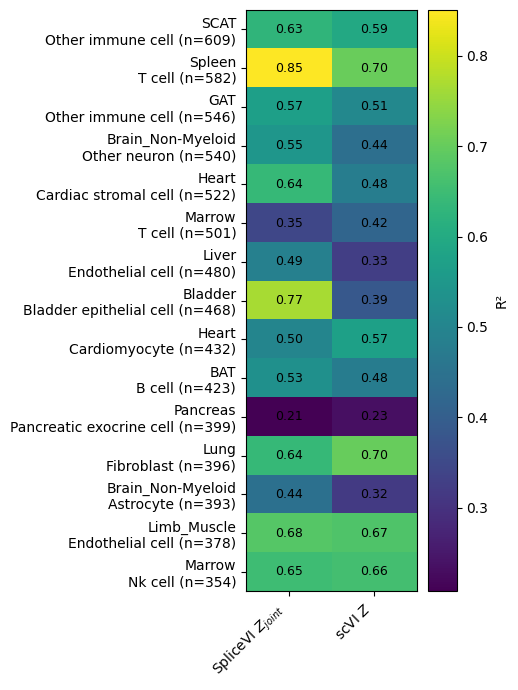

In [ ]:
# --- FIGURE: Age regression R² heatmap (Top-N most populated cell types by `n`, test split) ---
# USER INPUT:
splicevi_csv = "/gpfs/commons/home/svaidyanathan/splice_vi_partial_vae_sweep/batch_20251112_131914/mouse_trainandtest_REAL_cd=32_mn=50000_ld=25_lr=1e-5_0_scatter_PartialEncoderEDDI_pool=mean/figures/age_r2_by_tissue_celltype_train_test.csv"  # must contain: dataset, space, pair, r2, n
scvi_csv     = "/gpfs/commons/home/svaidyanathan/scvi_age/model/age_r2_by_tissue_celltype_train_test_target_ages_3_18_24_scvi_SCVI_age_only_20251112_131952.csv"      # must contain: dataset, (space optional), pair, r2, n
TOP_N = 15          # how many cell types per panel
START_RANK = 30      # 0-based rank (0–based in the sorted list)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_age(csv_path):
    df = pd.read_csv(csv_path)
    required = {"dataset","pair","r2","n"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns in {csv_path}: {missing}")
    # normalize
    df["dataset"]   = df["dataset"].astype(str).str.lower()
    if "space" not in df.columns:
        df["space"] = ""  # allow scVI files without an explicit space label
    else:
        df["space"] = df["space"].astype(str).str.lower()
    df["pair"] = df["pair"].astype(str)
    return df

sv = load_age(splicevi_csv)
sc = load_age(scvi_csv)

# keep only TEST rows
sv = sv[sv["dataset"] == "test"].copy()
sc = sc[sc["dataset"] == "test"].copy()

# ---- Select top-N most populated cell types by total n (SpliceVI test) ----
# If you prefer to aggregate counts across spaces, we sum n over all spaces per pair.
ct_counts = (
    sv.groupby("pair", as_index=False)["n"]
      .sum()
      .sort_values("n", ascending=False)
)

# e.g. START_RANK=0, TOP_N=25  -> ranks 0–24
#      START_RANK=25, TOP_N=25 -> ranks 25–49
top_cells = ct_counts["pair"].iloc[START_RANK:START_RANK + TOP_N].tolist()



# ---- Build R² matrix for required columns/spaces ----
# SpliceVI spaces we want
want_spaces = ["joint","splicing","expression"]
sv_sel = sv[sv["space"].isin(want_spaces)].copy()
sv_wide = sv_sel.pivot_table(index="pair", columns="space", values="r2", aggfunc="mean")

# scVI single latent (aggregate across any 'space' labels if present)
scvi_series = sc.groupby("pair")["r2"].mean()

# scQuint placeholder for now (replace when you have real CSV)
rng = np.random.default_rng(0)
scquint_series = pd.Series(
    data=rng.uniform(0.5, 0.5, size=len(top_cells)),
    index=top_cells,
    name="scQuint Z",
)

# Align to top cells
sv_top = sv_wide.reindex(index=top_cells)
scvi_top = scvi_series.reindex(top_cells)
scquint_top = scquint_series.reindex(top_cells)

# Final matrix in desired column order
heat_df = pd.DataFrame({
    "SpliceVI $Z_{joint}$":     sv_top.get("joint"),
    "scVI $Z$":               scvi_top,
}, index=top_cells)

# Optional: append counts to ytick labels
counts_map = dict(zip(ct_counts["pair"], ct_counts["n"]))
yticks = [f"{ct} (n={int(counts_map.get(ct, 0))})" for ct in heat_df.index]

# ---- Plot (matplotlib only) ----
fig, ax = plt.subplots(figsize=(5, 7))
im = ax.imshow(heat_df.values, aspect="auto")
ax.set_xticks(range(heat_df.shape[1]))
ax.set_xticklabels(heat_df.columns, rotation=45, ha="right")
yticks_wrapped = [s.replace(" | ", "\n") for s in yticks]
ax.set_yticks(range(len(yticks_wrapped)))
ax.set_yticklabels(yticks_wrapped)

# ax.set_title(f"Age regression $R^2$ (Top {len(top_cells)} most populated cell types, test)")
# annotate cells
ann = heat_df.round(3)
for i in range(heat_df.shape[0]):
    for j in range(heat_df.shape[1]):
        v = ann.iloc[i, j]
        if pd.notna(v):
            ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=9)

fig.colorbar(im, ax=ax, label="R²")
plt.tight_layout()
plt.savefig("fig_age_r2_heatmap_topN_by_n.pdf", dpi=300, bbox_inches="tight")
plt.show()


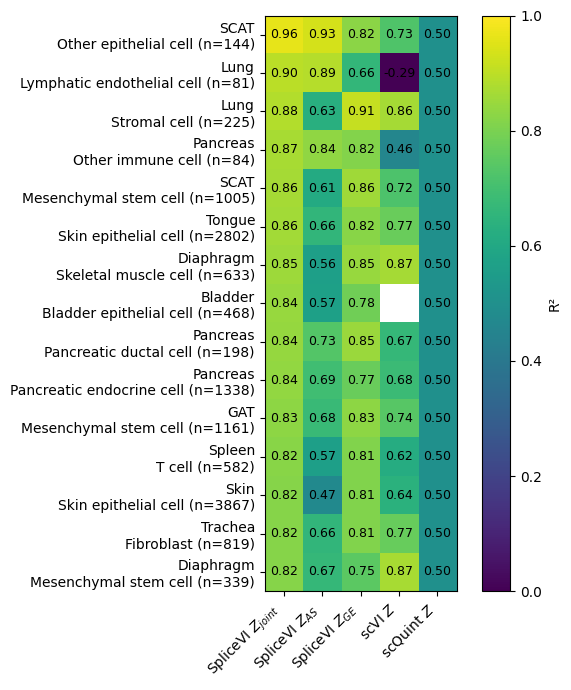

In [ ]:
# --- FIGURE: Age regression R² heatmap (Top-N cell types, test split) ---
# USER INPUT:
splicevi_csv = "/gpfs/commons/home/svaidyanathan/splice_vi_partial_vae_sweep/batch_20251026_163736/mouse_trainandtest_REAL_cd=32_mn=50000_ld=25_lr=1e-5_0_scatter_PartialEncoderEDDI_pool=sum/figures/age_r2_by_tissue_celltype_train_test.csv"
scvi_csv     = "/gpfs/commons/home/svaidyanathan/scvi_age/model/age_r2_by_tissue_celltype_train_test_target_ages_3_18_24_scvi_SCVI_age_only_20251024_143019.csv"
TOP_N = 15
ORDER_BY = "r2"      # options: "n" for most populated, "r2" for highest SpliceVI joint R^2
ASCENDING = False   # usually False for both modes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_age(csv_path):
    df = pd.read_csv(csv_path)
    required = {"dataset","pair","r2","n"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns in {csv_path}: {missing}")
    df["dataset"]   = df["dataset"].astype(str).str.lower()
    if "space" not in df.columns:
        df["space"] = ""
    else:
        df["space"] = df["space"].astype(str).str.lower()
    df["pair"] = df["pair"].astype(str)
    df["n"] = pd.to_numeric(df["n"], errors="coerce")
    df["r2"] = pd.to_numeric(df["r2"], errors="coerce")
    return df

sv = load_age(splicevi_csv)
sc = load_age(scvi_csv)

# keep only TEST rows
sv = sv[sv["dataset"] == "test"].copy()
sc = sc[sc["dataset"] == "test"].copy()

# SpliceVI spaces we want
want_spaces = ["joint","splicing","expression"]
sv_sel = sv[sv["space"].isin(want_spaces)].copy()

# Wide table for SpliceVI (rows=pairs, cols=spaces)
sv_wide = sv_sel.pivot_table(index="pair", columns="space", values="r2", aggfunc="mean")

# Counts per pair (sum over spaces)
ct_counts = sv_sel.groupby("pair", as_index=False)["n"].sum().sort_values("n", ascending=False)

# ---- Top-N selection toggle ----
if ORDER_BY.lower() == "n":
    order_series = ct_counts.set_index("pair")["n"]
elif ORDER_BY.lower() == "r2":
    if "joint" in sv_wide.columns:
        order_series = sv_wide["joint"].fillna(-1.0)
    else:
        # fallback: average across spaces
        order_series = sv_wide.mean(axis=1).fillna(-1.0)
else:
    raise ValueError("ORDER_BY must be 'n' or 'r2'")

# sort and pick top-N
order_series = order_series.sort_values(ascending=ASCENDING)
top_pairs = order_series.index[:TOP_N].tolist()

# slice matrices to top-N
sv_top = sv_wide.reindex(index=top_pairs)

# scVI single latent (aggregate if multiple space labels exist)
scvi_series = sc.groupby("pair")["r2"].mean().reindex(top_pairs)

# scQuint placeholder (replace when you have real CSV)
rng = np.random.default_rng(0)
scquint_series = pd.Series(
    data=rng.uniform(0.5, 0.5, size=len(top_pairs)),
    index=top_pairs,
    name="scQuint Z",
)

# Final matrix in desired column order
heat_df = pd.DataFrame({
    "SpliceVI $Z_{joint}$":    sv_top.get("joint"),
    "SpliceVI $Z_{AS}$":       sv_top.get("splicing"),
    "SpliceVI $Z_{GE}$":       sv_top.get("expression"),
    "scVI $Z$":                scvi_series,
    "scQuint $Z$":             scquint_series,
}, index=top_pairs)

# ytick labels with counts
counts_map = dict(zip(ct_counts["pair"], ct_counts["n"]))
yticks = [f"{p} (n={int(counts_map.get(p, 0))})" for p in heat_df.index]
yticks_wrapped = [s.replace(" | ", "\n") for s in yticks]

# ---- Plot ----
fig, ax = plt.subplots(figsize=(6, 7))
im = ax.imshow(heat_df.values, vmin=0, vmax=1)
ax.set_xticks(range(heat_df.shape[1]))
ax.set_xticklabels(heat_df.columns, rotation=45, ha="right")
ax.set_yticks(range(len(yticks_wrapped)))
ax.set_yticklabels(yticks_wrapped)
# annotate cells
ann = heat_df.round(3)
for i in range(heat_df.shape[0]):
    for j in range(heat_df.shape[1]):
        v = ann.iloc[i, j]
        if pd.notna(v):
            ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=9)

fig.colorbar(im, ax=ax, label="R²")
plt.tight_layout()
plt.savefig(f"fig_age_r2_heatmap_top{TOP_N}_orderby_{ORDER_BY}.pdf", dpi=300, bbox_inches="tight")
plt.show()


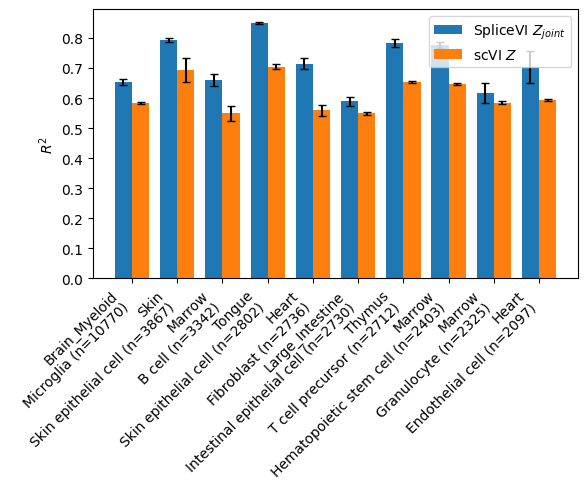

In [ ]:
# --- FIGURE: Age regression R² bar chart (Top-N most populated cell types by `n`, test split) ---
# USER INPUT:
splicevi_csvs = [
    "/gpfs/commons/home/svaidyanathan/splice_vi_partial_vae_sweep/batch_20251112_131914/mouse_trainandtest_REAL_cd=32_mn=50000_ld=25_lr=1e-5_0_scatter_PartialEncoderEDDI_pool=mean/figures/age_r2_by_tissue_celltype_train_test.csv",
    "/gpfs/commons/home/svaidyanathan/splice_vi_partial_vae_sweep/batch_20251112_131914/mouse_trainandtest_REAL_cd=32_mn=50000_ld=25_lr=1e-5_2_scatter_PartialEncoderEDDI_pool=mean/figures/age_r2_by_tissue_celltype_train_test.csv",
    "/gpfs/commons/home/svaidyanathan/splice_vi_partial_vae_sweep/batch_20251111_114606/mouse_trainandtest_REAL_cd=32_mn=50000_ld=25_lr=1e-5_0_scatter_PartialEncoderEDDI_pool=mean/figures/age_r2_by_tissue_celltype_train_test.csv"
]
scvi_csvs = [
    "/gpfs/commons/home/svaidyanathan/scvi_age/model/age_r2_by_tissue_celltype_train_test_target_ages_3_18_24_scvi_SCVI_age_only_20251112_131952.csv",
    "/gpfs/commons/home/svaidyanathan/scvi_age/model/age_r2_by_tissue_celltype_train_test_target_ages_3_18_24_scvi_SCVI_age_only_20251112_131952.csv",
    "/gpfs/commons/home/svaidyanathan/scvi_age/model/age_r2_by_tissue_celltype_train_test_target_ages_3_18_24_scvi_SCVI_age_only_20251110_133200.csv"
]

TOP_N = 10          # how many cell types per panel
START_RANK = 0     # 0-based rank in descending n

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def load_age(csv_path):
    df = pd.read_csv(csv_path)
    required = {"dataset", "pair", "r2", "n"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns in {csv_path}: {missing}")
    df["dataset"] = df["dataset"].astype(str).str.lower()
    if "space" not in df.columns:
        df["space"] = ""  # scVI files without explicit space
    else:
        df["space"] = df["space"].astype(str).str.lower()
    df["pair"] = df["pair"].astype(str)
    return df


# ---------- Load and concatenate all SpliceVI runs ----------
sv_list = [load_age(p) for p in splicevi_csvs]
sv_all = pd.concat(sv_list, ignore_index=True)
sv_all = sv_all[sv_all["dataset"] == "test"].copy()

# Use only joint space for ranking and plotting
sv_joint = sv_all[sv_all["space"] == "joint"].copy()
if sv_joint.empty:
    raise ValueError("No SpliceVI rows with space=='joint' in test dataset")

# Rank cell types by total n across all SpliceVI runs
ct_counts = (
    sv_joint.groupby("pair", as_index=False)["n"]
    .sum()
    .sort_values("n", ascending=False)
)

top_cells = ct_counts["pair"].iloc[START_RANK : START_RANK + TOP_N].tolist()
if not top_cells:
    raise ValueError("No cell types selected. Check START_RANK and TOP_N relative to ct_counts length.")

# ---------- Load and concatenate all scVI runs ----------
sc_list = [load_age(p) for p in scvi_csvs]
sc_all = pd.concat(sc_list, ignore_index=True)
sc_all = sc_all[sc_all["dataset"] == "test"].copy()

# scVI may or may not have a 'space' label, but we ignore it and treat as a single embedding
# Keep only pairs that are in top_cells for consistency
sc_all = sc_all[sc_all["pair"].isin(top_cells)].copy()
sv_joint = sv_joint[sv_joint["pair"].isin(top_cells)].copy()

# ---------- Aggregate R² per method (mean ± std across runs) ----------
# SpliceVI joint
sv_stats = (
    sv_joint.groupby("pair")["r2"]
    .agg(["mean", "std"])
    .rename(columns={"mean": "sv_mean", "std": "sv_std"})
)

# scVI
sc_stats = (
    sc_all.groupby("pair")["r2"]
    .agg(["mean", "std"])
    .rename(columns={"mean": "sc_mean", "std": "sc_std"})
)

# Make sure we include all top_cells in the same order
# If a method is missing a pair, it will show NaN
index = pd.Index(top_cells, name="pair")
stats = pd.DataFrame(index=index)
stats = stats.join(sv_stats, how="left")
stats = stats.join(sc_stats, how="left")

# Drop rows where both methods are NaN (should not normally happen)
stats = stats.dropna(how="all", subset=["sv_mean", "sc_mean"])

# Optional: append counts to labels (using SpliceVI n across runs)
counts_map = dict(zip(ct_counts["pair"], ct_counts["n"]))
labels = stats.index.tolist()
labels_with_n = [f"{ct} (n={int(counts_map.get(ct, 0))})" for ct in labels]
labels_wrapped = [s.replace(" | ", "\n") for s in labels_with_n]

# ---------- Prepare bar data ----------
x = np.arange(len(stats))
width = 0.38

sv_means = stats["sv_mean"].values
sv_stds = stats["sv_std"].values
sc_means = stats["sc_mean"].values
sc_stds = stats["sc_std"].values

# Replace NaN stds with 0 for plotting
sv_stds_plot = np.nan_to_num(sv_stds, nan=0.0)
sc_stds_plot = np.nan_to_num(sc_stds, nan=0.0)

# Replace NaN means with 0 but mark them so you know they were missing
# (you can also choose to mask these entirely instead)
sv_means_plot = np.nan_to_num(sv_means, nan=0.0)
sc_means_plot = np.nan_to_num(sc_means, nan=0.0)

# ---------- Plot grouped bar chart ----------
fig_w = max(6, 0.45 * len(stats))
fig, ax = plt.subplots(figsize=(fig_w, 5))

ax.bar(x - width / 2, sv_means_plot, width,
       yerr=sv_stds_plot, capsize=3, label="SpliceVI $Z_{joint}$")
ax.bar(x + width / 2, sc_means_plot, width,
       yerr=sc_stds_plot, capsize=3, label="scVI $Z$")

ax.set_xticks(x)
ax.set_xticklabels(labels_wrapped, rotation=45, ha="right")

ax.set_ylabel("$R^2$")
# ax.set_title(f"Age regression $R^2$ (ranks {START_RANK}–{START_RANK+len(stats)-1}, test split)")
ax.legend(loc="upper right")

plt.tight_layout()
plt.savefig("fig_age_r2_bar_topN_by_n.pdf", dpi=300, bbox_inches="tight")
plt.show()


103
Unique SpliceVI test pairs: 103
Unique scVI test pairs: 10


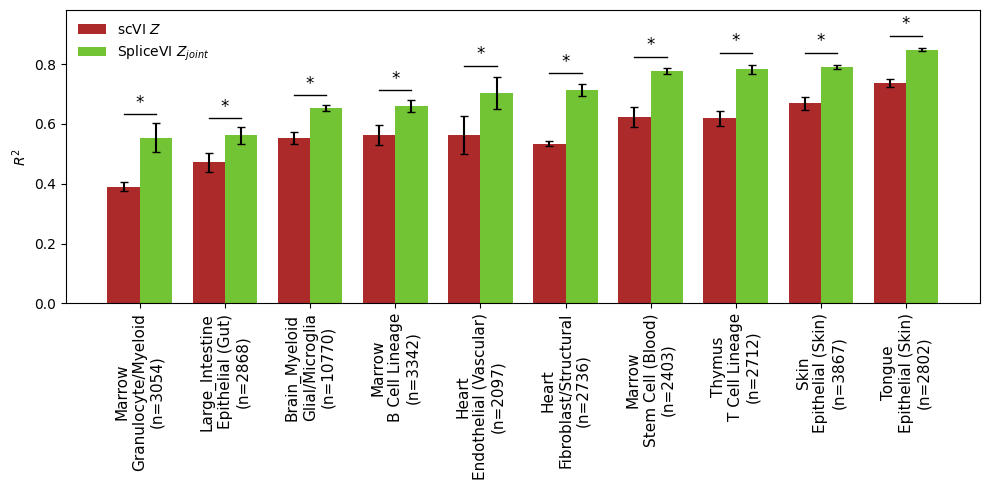

In [ ]:
# --- FIGURE: Age regression R² bar chart with error bars and significance (scVI first, sorted by SpliceVI R²) ---

# USER INPUT:
splicevi_csvs = [
"/gpfs/commons/home/svaidyanathan/splice_vi_partial_vae_eval/batch_20251123_014453/run_02/eval_models/figures/age_r2_by_tissue_celltype_train_test.csv",
"/gpfs/commons/home/svaidyanathan/splice_vi_partial_vae_eval/batch_20251123_014453/run_01/eval_models/figures/age_r2_by_tissue_celltype_train_test.csv",
"/gpfs/commons/home/svaidyanathan/splice_vi_partial_vae_eval/batch_20251123_014453/run_03/eval_models/figures/age_r2_by_tissue_celltype_train_test.csv"
]

scvi_csvs = [
"/gpfs/commons/home/svaidyanathan/scvi_age/model/age_r2_by_tissue_celltype_train_test_target_ages_3_18_24_scvi_SCVI_age_only_20251122_163137.csv",
"/gpfs/commons/home/svaidyanathan/scvi_age/model/age_r2_by_tissue_celltype_train_test_target_ages_3_18_24_scvi_SCVI_age_only_20251123_130609.csv",
"/gpfs/commons/home/svaidyanathan/scvi_age/model/age_r2_by_tissue_celltype_train_test_target_ages_3_18_24_scvi_SCVI_age_only_20251122_182341.csv"
]

TOP_N = 10
START_RANK = 0

# Plot customization
SV_COLOR = "#73c434"   # SpliceVI color
SC_COLOR = "#ad2a2a"     # scVI color
ALPHA_SIG = 0.05

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind


def load_age(csv_path):
    df = pd.read_csv(csv_path)
    required = {"dataset","pair","r2","n"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns in {csv_path}: {missing}")
    df["dataset"] = df["dataset"].astype(str).str.lower()
    df["pair"] = df["pair"].astype(str)
    df["space"] = df.get("space", "").astype(str).str.lower()
    return df


# ----- Load SpliceVI -----
sv_list = [load_age(p) for p in splicevi_csvs]
sv_all = pd.concat(sv_list, ignore_index=True)
sv_all = sv_all[sv_all["dataset"] == "test"].copy()

sv_joint = sv_all[sv_all["space"] == "joint"].copy()
unique_sv_pairs = sv_joint["pair"].nunique()
if sv_joint.empty:
    raise ValueError("No SpliceVI rows with space=='joint'")

ct_counts = (
    sv_joint.groupby("pair", as_index=False)["n"]
    .sum()
    .sort_values("n", ascending=False)
)
print(len(ct_counts["pair"]))
top_cells = ct_counts["pair"].iloc[START_RANK:START_RANK + TOP_N].tolist()
if not top_cells:
    raise ValueError("No cell types selected.")

# ----- Load scVI -----
sc_list = [load_age(p) for p in scvi_csvs]
sc_all = pd.concat(sc_list, ignore_index=True)
sc_all = sc_all[sc_all["dataset"] == "test"].copy()

sv_joint = sv_joint[sv_joint["pair"].isin(top_cells)].copy()
unique_sc_pairs = sc_all["pair"].nunique()
sc_all = sc_all[sc_all["pair"].isin(top_cells)].copy()


# Assuming sv_all and sc_all already filtered to dataset == "test"

unique_sv_pairs = sv_all["pair"].nunique()


print("Unique SpliceVI test pairs:", unique_sv_pairs)
print("Unique scVI test pairs:", unique_sc_pairs)


# ----- Aggregate -----
sv_stats = (
    sv_joint.groupby("pair")["r2"]
    .agg(["mean","std"])
    .rename(columns={"mean":"sv_mean","std":"sv_std"})
)

sc_stats = (
    sc_all.groupby("pair")["r2"]
    .agg(["mean","std"])
    .rename(columns={"mean":"sc_mean","std":"sc_std"})
)

index = pd.Index(top_cells, name="pair")
stats = pd.DataFrame(index=index)
stats = stats.join(sv_stats, how="left").join(sc_stats, how="left")

stats = stats.dropna(how="all", subset=["sv_mean","sc_mean"])

# ----- Sort by SpliceVI mean R² (ascending) -----
stats = stats.sort_values("sv_mean", ascending=True)

# ----- Labels -----
counts_map = dict(zip(ct_counts["pair"], ct_counts["n"]))
labels = stats.index.tolist()
labels_with_n = [f"{ct}\n(n={int(counts_map.get(ct,0))})" for ct in labels]
labels_wrapped = [s.replace(" | ","\n") for s in labels_with_n]

# ----- Prepare bar data -----
x = np.arange(len(stats))
width = 0.38

sv_means = stats["sv_mean"].fillna(0).values
sv_stds  = stats["sv_std"].fillna(0).values
sc_means = stats["sc_mean"].fillna(0).values
sc_stds  = stats["sc_std"].fillna(0).values

# ----- Significance -----
sv_groups = sv_joint.groupby("pair")["r2"].apply(list)
sc_groups = sc_all.groupby("pair")["r2"].apply(list)

pvals = []
for pair in stats.index:
    sv_vals = np.array(sv_groups.get(pair, []))
    sc_vals = np.array(sc_groups.get(pair, []))
    if len(sv_vals) >= 2 and len(sc_vals) >= 2:
        _, p = ttest_ind(sv_vals, sc_vals, equal_var=False, nan_policy="omit")
    else:
        p = np.nan
    pvals.append(p)

stats["p_value"] = pvals

# ----- Plot -----
fig_w = max(10, 0.45 * len(stats))
fig, ax = plt.subplots(figsize=(fig_w,5))

# scVI FIRST (left)
ax.bar(
    x - width/2, sc_means, width,
    yerr=sc_stds, capsize=3,
    label="scVI $Z$", color=SC_COLOR
)

# SpliceVI SECOND (right)
ax.bar(
    x + width/2, sv_means, width,
    yerr=sv_stds, capsize=3,
    label="SpliceVI $Z_{joint}$", color=SV_COLOR
)

ax.set_xticks(x)
ax.set_xticklabels(labels_wrapped, rotation=90, ha="center", va = "top", fontsize = 11)
ax.set_ylabel("$R^2$")

# Legend on the right
ax.legend(
    loc="upper left",
    frameon=False
)

# ----- Asterisks -----
y_max_vals = np.maximum(sc_means + sc_stds, sv_means + sv_stds)
ax.set_ylim(top=max(y_max_vals)*1.15)

for i, p in enumerate(stats["p_value"]):
    if np.isfinite(p) and p < ALPHA_SIG:
        y = y_max_vals[i] * 1.05
        x1, x2 = x[i] - width/2, x[i] + width/2
        xm = x[i]
        ax.plot([x1, x2], [y, y], color="black", linewidth=1)
        ax.text(xm, y*1.01, "*", ha="center", va="bottom", fontsize=12)

plt.tight_layout()
plt.savefig("fig_age_r2_bar_sorted_scvi_first.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [1]:
import mudata as mu

# Path to your .h5mu file
mdata_path = "/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/MOUSE_SPLICING_FOUNDATION/MODEL_INPUT/102025/train_70_30_model_ready_combined_gene_expression_aligned_splicing_20251009_024406_with_latents.h5mu"

# Load the MuData object
mdata = mu.read(mdata_path)

mdata

/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


MuData object with n_obs × n_vars = 99620 × 100403
  obs:	'_scvi_batch', '_scvi_labels', 'age', 'age_numeric', 'annotated_junction_reads', 'batch', 'broad_cell_type', 'cell_clean', 'cell_id', 'cell_id_index', 'cell_name', 'cell_ontology_class', 'dataset', 'leiden_scVI', 'library_size', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_is_rRNA', 'medium_cell_type', 'mouse.id', 'n_detected_annotated_junctions', 'n_detected_unannotated_junctions', 'n_genes_by_counts', 'pct_counts_is_rRNA', 'seqtech', 'sex', 'specific_cell_type', 'subtissue', 'subtissue_clean', 'tissue', 'total_counts', 'total_counts_is_rRNA', 'total_junction_reads', 'unannotated_junction_reads', 'age_group', 'tissue_celltype', '_indices'
  var:	'index', 'gene_name', 'gene_id', 'aging_lifespan_effect', 'aging_longevity_influence', 'aging_gene', 'ID', 'modality'
  uns:	'_scvi_manager_uuid', '_scvi_uuid'
  obsm:	'X_library_size'
  2 modalities
    rna:	99620 x 10572
      obs:	'_scvi_batch', '_scvi_labels', 'age', 'age_numeric', 'annotated_junction_reads', 'batch', 'broad_cell_type', 'cell_clean', 'cell_id', 'cell_id_index', 'cell_name', 'cell_ontology_class', 'dataset', 'leiden_scVI', 'library_size', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_is_rRNA', 'medium_cell_type', 'mouse.id', 'n_detected_annotated_junctions', 'n_detected_unannotated_junctions', 'n_genes_by_counts', 'pct_counts_is_rRNA', 'seqtech', 'sex', 'specific_cell_type', 'subtissue', 'subtissue_clean', 'tissue', 'total_counts', 'total_counts_is_rRNA', 'total_junction_reads', 'unannotated_junction_reads', 'age_group', 'tissue_celltype', 'X_library_size'
      var:	'index', 'gene_name', 'gene_id', 'mean_transcript_length', 'mean_intron_length', 'num_transcripts', 'gene_biotype', 'is_rRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'RBP_gene', 'is_hvg', 'is_rbp', 'gene_name_upper', 'aging_gene_name', 'aging_lifespan_effect', 'aging_longevity_influence', 'aging_gene', 'ID', 'modality'
      uns:	'_scvi_manager_uuid', '_scvi_uuid', 'gene_selection', 'leiden_scVI', 'leiden_scVI_colors', 'leiden_scVI_params', 'neighbors', 'scvi_linear', 'umap'
      obsm:	'X_latent_expression', 'X_latent_joint', 'X_latent_splicing', 'X_library_size', 'X_normalized_scVI_linear', 'X_scVI_linear', 'X_umap'
      varm:	'scVI_linear_gene_loadings'
      layers:	'length_norm', 'log_norm', 'raw_counts'
      obsp:	'connectivities', 'distances'
    splicing:	99620 x 89831
      obs:	'_scvi_batch', '_scvi_labels', 'age', 'age_numeric', 'annotated_junction_reads', 'batch', 'broad_cell_type', 'cell_clean', 'cell_id', 'cell_id_index', 'cell_name', 'cell_ontology_class', 'dataset', 'leiden_scVI', 'library_size', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_is_rRNA', 'medium_cell_type', 'mouse.id', 'n_detected_annotated_junctions', 'n_detected_unannotated_junctions', 'n_genes_by_counts', 'pct_counts_is_rRNA', 'seqtech', 'sex', 'specific_cell_type', 'subtissue', 'subtissue_clean', 'tissue', 'total_counts', 'total_counts_is_rRNA', 'total_junction_reads', 'unannotated_junction_reads', 'age_group', 'tissue_celltype'
      var:	'index', 'junction_id', 'event_id', 'splice_motif', 'annotation_status', 'gene_name', 'gene_id', 'num_junctions', 'position_off_5_prime', 'position_off_3_prime', 'CountJuncs', 'junction_id_index', 'n_cells_detected', 'confidence', 'aging_gene', 'aging_lifespan_effect', 'aging_longevity_influence', 'ID', 'modality'
      obsm:	'X_library_size'
      layers:	'cell_by_cluster_matrix', 'cell_by_junction_matrix', 'junc_ratio', 'psi_mask'

In [ ]:
import matplotlib.cm as cm

def plot_umap(ge_adata, rep_input, variable_name, PLOTS_DIR, num_groups=None):
    print(f"Generating UMAPs for {rep_input} and {variable_name}...")

    # Identify top N groups by frequency
    if num_groups is not None:
        top_groups = ge_adata.obs[variable_name].value_counts().head(num_groups).index.tolist()
        print(f"The top {num_groups} groups are: {top_groups}")
    else:
        top_groups = ge_adata.obs[variable_name].unique().tolist()
        num_groups = len(top_groups)
        print(f"The unique groups are: {top_groups}")

    # Create a simplified group column
    ge_adata.obs['group_highlighted'] = 'Other'
    ge_adata.obs.loc[ge_adata.obs[variable_name].isin(top_groups), 'group_highlighted'] = \
        ge_adata.obs[variable_name]

    # Assign colors using tab20
    cmap = cm.get_cmap('tab20', len(top_groups))
    colors = [cmap(i) for i in range(len(top_groups))]
    color_dict = {group: colors[i] for i, group in enumerate(top_groups)}
    color_dict['Other'] = [0.9, 0.9, 0.9, 1.0]  # very light gray for background

    # Plot UMAP
    plt.figure(figsize=(8, 5))
    sc.pl.umap(
        ge_adata,
        color='group_highlighted',
        palette=color_dict,
        show=True,
        frameon=True,
        legend_fontsize=10,
        legend_loc='right margin'
    )
   
    plt.tight_layout(rect=[0, 0, 1, 0.95])


plot_umap(mdata["rna"], )

In [67]:

import scanpy as sc
# Choose which latent space to UMAP
space = 'joint'
latent_key = f"X_latent_{space}"          # or "X_latent_expression", "X_latent_splicing"

# Build neighbors directly on that obsm representation
sc.pp.neighbors(
    mdata["rna"],
    use_rep=latent_key,   # tells Scanpy to use adata.obsm[latent_key]
    n_neighbors=15
)

# Compute UMAP
sc.tl.umap(mdata["rna"])


mdata["rna"].obsm[f"X_umap_{space}"] = mdata["rna"].obsm["X_umap"]

In [68]:
print(mdata)

MuData object with n_obs × n_vars = 99620 × 100403
  obs:	'_scvi_batch', '_scvi_labels', 'age', 'age_numeric', 'annotated_junction_reads', 'batch', 'broad_cell_type', 'cell_clean', 'cell_id', 'cell_id_index', 'cell_name', 'cell_ontology_class', 'dataset', 'leiden_scVI', 'library_size', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_is_rRNA', 'medium_cell_type', 'mouse.id', 'n_detected_annotated_junctions', 'n_detected_unannotated_junctions', 'n_genes_by_counts', 'pct_counts_is_rRNA', 'seqtech', 'sex', 'specific_cell_type', 'subtissue', 'subtissue_clean', 'tissue', 'total_counts', 'total_counts_is_rRNA', 'total_junction_reads', 'unannotated_junction_reads', 'age_group', 'tissue_celltype', '_indices'
  var:	'index', 'gene_name', 'gene_id', 'aging_lifespan_effect', 'aging_longevity_influence', 'aging_gene', 'ID', 'modality'
  uns:	'_scvi_manager_uuid', '_scvi_uuid'
  obsm:	'X_library_size'
  2 modalities
    rna:	99620 x 10572
      obs:	'_scvi_batch', '_scvi_labels'

In [59]:

top_groups = mdata["rna"].obs["medium_cell_type"].value_counts().head(10).index.tolist()
print(f"The top 10 groups are: {top_groups}")


The top 10 groups are: ['Excitatory Neurons (Cortical)', 'Glial/Microglia', 'B Cell Lineage', 'Epithelial (Skin)', 'T Cell Lineage', 'Granulocyte/Myeloid', 'Inhibitory Neurons (Vip+)', 'Stem Cell/Stromal', 'Fibroblast/Structural', 'Inhibitory Neurons (Sst+)']


In [60]:
import os
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cmap = cm.get_cmap('tab20', len(top_groups))
colors = [cmap(i) for i in range(len(top_groups))]
color_dict = {group: colors[i] for i, group in enumerate(top_groups)}
color_dict['Other'] = [0.9, 0.9, 0.9, 1.0]  # very light gray for background

mdata["rna"].obs['group_highlighted'] = 'Other'
mdata["rna"].obs.loc[mdata["rna"].obs["medium_cell_type"].isin(top_groups), 'group_highlighted'] = \
mdata["rna"].obs["medium_cell_type"]

cmap = cm.get_cmap('tab20', len(top_groups))
colors = [cmap(i) for i in range(len(top_groups))]
color_dict = {group: colors[i] for i, group in enumerate(top_groups)}
color_dict['Other'] = [0.9, 0.9, 0.9, 1.0]  # very light gray for background



/scratch/ipykernel_881349/709336891.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(top_groups))
/scratch/ipykernel_881349/709336891.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(top_groups))


In [101]:
adata = mdata["rna"]
X = adata.obsm["X_umap_splicing"]

X.min(axis=0), X.max(axis=0)


(array([-6.7028217, -7.776826 ], dtype=float32),
 array([18.986618, 14.393356], dtype=float32))

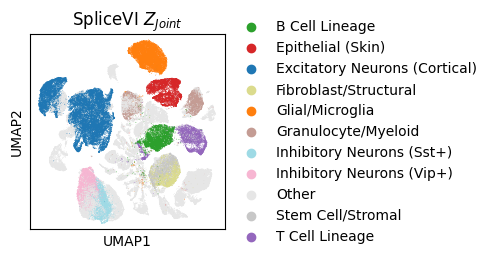

In [109]:
space = "joint"

fig, ax = plt.subplots(figsize=(5, 5))   # square figure
ax.set_box_aspect(1)
ax.set_aspect(1)

sc.pl.embedding(
    mdata["rna"],
    basis=f"X_umap_{space}",
    color='group_highlighted',
    palette=color_dict,
    show=False,
    frameon=True,
    legend_loc="right margin",
    legend_fontsize=10,
    title=None,
    ax = ax
)

ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
plt.title('SpliceVI $Z_{Joint}$')
plt.tight_layout()

plt.savefig(f"/gpfs/commons/home/svaidyanathan/repos/multivi_tools_splicing/multivi_splice_utils/jupyter_notebooks/umap_SpliceVI_Z_{space}.pdf", format="pdf")



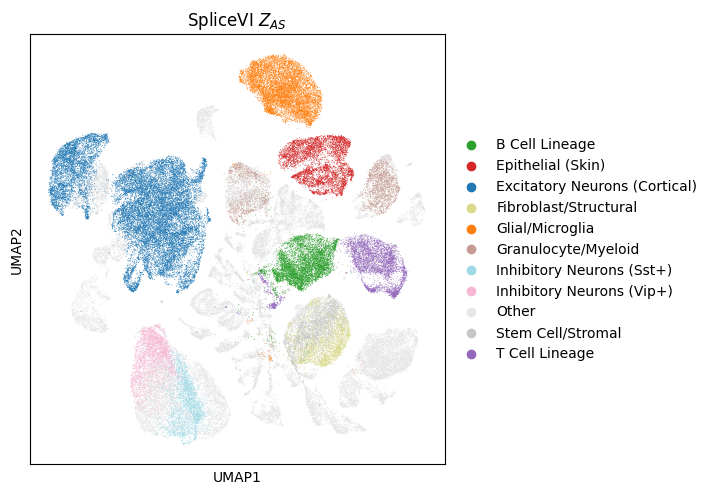

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

adata = mdata["rna"]

fig, ax = plt.subplots(figsize=(7, 7))   # square figure
ax.set_aspect('equal')                   # force square aspect

sc.pl.umap(
    adata,
    color='group_highlighted',
    palette=color_dict,
    show=False,
    frameon=True,
    legend_fontsize=10,
    legend_loc='right margin',
    ax=ax                                 # plot on our square axis
)

ax.set_aspect('equal')   

plt.title('SpliceVI $Z_{AS}$')
plt.tight_layout()
plt.show()



plt.savefig("splicevi_umap_AS.pdf", format="pdf", dpi=300, bbox_inches="tight")

plt.show()

In [63]:
print(mdata["rna"])

AnnData object with n_obs × n_vars = 99620 × 10572
    obs: '_scvi_batch', '_scvi_labels', 'age', 'age_numeric', 'annotated_junction_reads', 'batch', 'broad_cell_type', 'cell_clean', 'cell_id', 'cell_id_index', 'cell_name', 'cell_ontology_class', 'dataset', 'leiden_scVI', 'library_size', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_is_rRNA', 'medium_cell_type', 'mouse.id', 'n_detected_annotated_junctions', 'n_detected_unannotated_junctions', 'n_genes_by_counts', 'pct_counts_is_rRNA', 'seqtech', 'sex', 'specific_cell_type', 'subtissue', 'subtissue_clean', 'tissue', 'total_counts', 'total_counts_is_rRNA', 'total_junction_reads', 'unannotated_junction_reads', 'age_group', 'tissue_celltype', 'X_library_size', 'group_highlighted'
    var: 'index', 'gene_name', 'gene_id', 'mean_transcript_length', 'mean_intron_length', 'num_transcripts', 'gene_biotype', 'is_rRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_

In [ ]:
plt.figure(figsize=(8, 5))
sc.pl.embedding(
    mdata["rna"],
    basis="X_umap",
    color=c_spec["plot_col"],
    palette=c_spec["palette"],
    show=False,
    frameon=True,
    legend_loc="right margin",
    legend_fontsize=10,
    title=None,
)

title_suffix = f"(Top {len(c_spec['top_cts'])} Highlighted)"
plt.title(f"UMAP by {col} {title_suffix}")
plt.tight_layout(rect=[0,0,1,0.95])

out_path = f"{args.fig_dir}/umap_group_{col}_{name}_top{len(c_spec['top_cts'])}.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
wandb.log({f"umap/{col}_{name}": wandb.Image(out_path)})
plt.close()

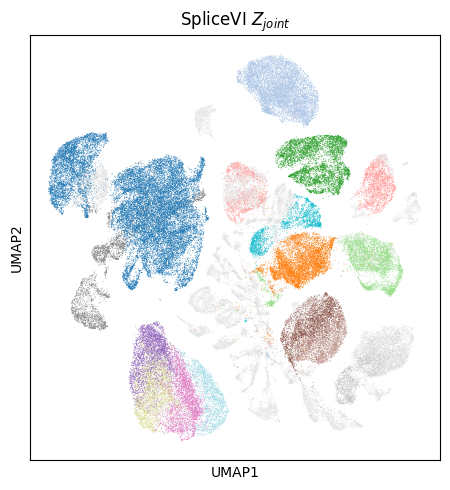

In [44]:
import matplotlib.pyplot as plt
import scanpy as sc

adata = mdata["rna"]

fig, ax = plt.subplots(figsize=(5, 5))   # square figure
ax.set_aspect('equal')                   # force square aspect

sc.pl.umap(
    adata,
    color='group_highlighted',
    palette=color_dict,
    show=False,
    frameon=True,
    legend_fontsize=10,
    legend_loc=None,
    ax=ax                                 # plot on our square axis
)

plt.title('SpliceVI $Z_{joint}$')
plt.tight_layout()
plt.show()





/scratch/ipykernel_881349/265855003.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


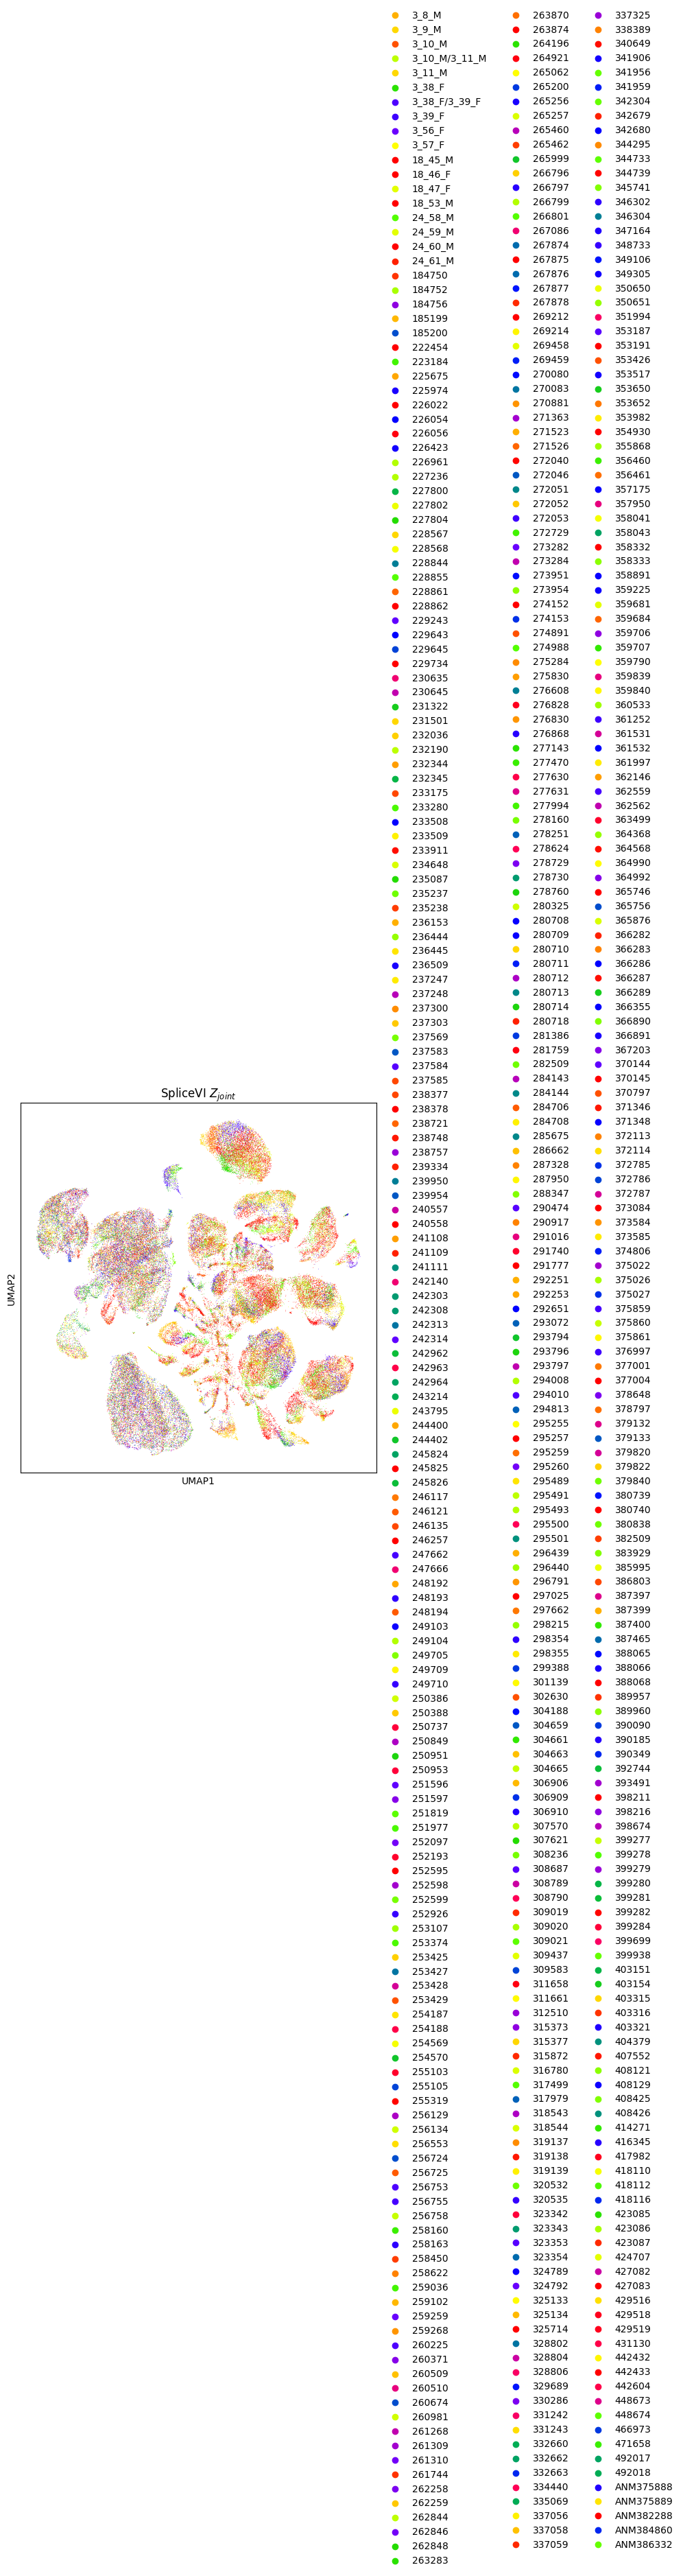

In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np

adata = mdata["rna"]

# Get unique categories
cats = adata.obs["mouse.id"].unique().tolist()
n = len(cats)

# Use a robust qualitative colormap
# For MANY categories, tab20 or hsv are common; hsv gives maximal separation.
cmap = plt.cm.prism

# Sample colors evenly
colors = [cmap(i / n) for i in range(n)]

# Build dict
color_dict = {cat: colors[i] for i, cat in enumerate(cats)}

color_dict

fig, ax = plt.subplots(figsize=(7, 7))
ax.set_aspect('equal')

sc.pl.umap(
    adata,
    color='mouse.id',
    palette=color_dict,
    show=False,
    frameon=True,
    legend_loc='right margin',
    ax=ax
)

plt.title('SpliceVI $Z_{joint}$')
plt.tight_layout()
plt.show()





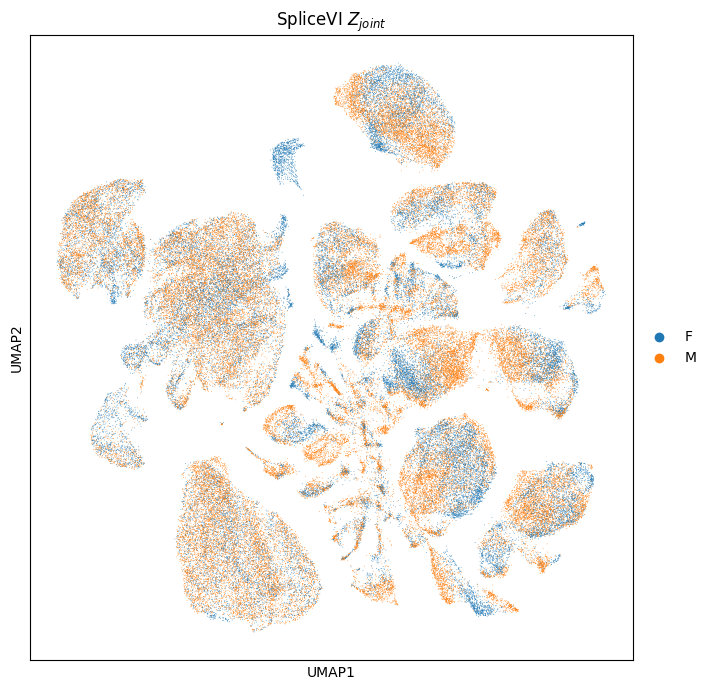

In [38]:
import matplotlib.pyplot as plt
import scanpy as sc

import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np

fig, ax = plt.subplots(figsize=(7, 7))
ax.set_aspect('equal')

sc.pl.umap(
    adata,
    color='sex',
    show=False,
    frameon=True,
    legend_loc='right margin',
    ax=ax
)

plt.title('SpliceVI $Z_{joint}$')
plt.tight_layout()
plt.show()



